# Medical Image Analysis Project: Pneumonia Detection

## Overview
In this capstone project, you will apply the deep learning techniques learned in this course to a real-world medical imaging problem: **Pneumonia Detection from Chest X-Rays**.

Specifically, you will work with the **PneumoniaMNIST** dataset, a binary classification subset of the MedMNIST collection. Your goal is to build a robust classifier that distinguishes between 'Normal' and 'Pneumonia' cases.

Unlike previous tutorials where models were prescribed, **you interpret the data and choose the model architecture** best suited for the task. You will be evaluated not just on accuracy, but on your design choices, rigorous evaluation, and interpretability of results.

## 1. Setup and Data Loading
First, we install and load the necessary libraries. We rely on `medmnist` for data retrieval and `torch` for modeling.

In [1]:
# !pip install medmnist # Uncomment if running in Colab

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import medmnist
from medmnist import INFO, Evaluator
import matplotlib.pyplot as plt
import numpy as np

print(f"MedMNIST v{medmnist.__version__} @ {medmnist.__file__}")

MedMNIST v3.0.2 @ /home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/medmnist/__init__.py


### Data Understanding
We use **PneumoniaMNIST**, which contains cropped chest X-ray images. The task is binary classification: **0 (Normal)** vs **1 (Pneumonia)**.

In [2]:
data_flag = 'pneumoniamnist'
download = True

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# Basic transform for visualization/baseline
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

train_dataset = DataClass(split='train', transform=data_transform, download=download)
val_dataset = DataClass(split='val', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

100%|██████████| 4.17M/4.17M [00:00<00:00, 4.36MB/s]


Train samples: 4708
Val samples: 524
Test samples: 624


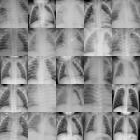

In [3]:
# Visualization of samples
train_dataset.montage(length=5)

### Class Distribution Analysis
Before proceeding, it is crucial to understand if our classes are balanced. Imbalanced datasets can lead to biased models that predict the majority class. Check the counts below.

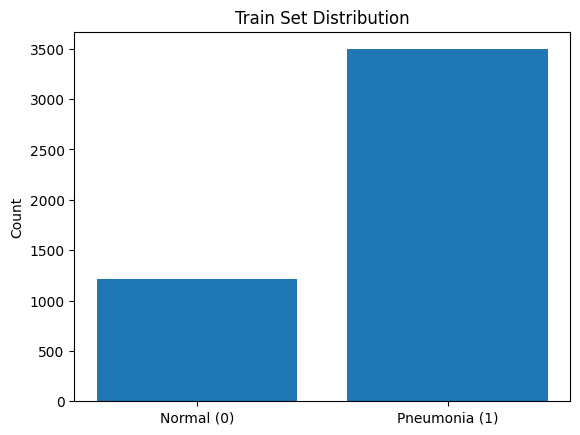

Counts: {'Normal': 1214, 'Pneumonia': 3494}


In [4]:
# Analyze Class Distribution
def plot_class_distribution(dataset, title='Class Distribution'):
    targets = [y for _, y in dataset]
    targets = np.array(targets).squeeze()
    unique, counts = np.unique(targets, return_counts=True)
    plt.bar(unique, counts)
    plt.xticks(unique, ['Normal (0)', 'Pneumonia (1)'])
    plt.title(title)
    plt.ylabel('Count')
    plt.show()
    print(f"Counts: {dict(zip(['Normal', 'Pneumonia'], counts))}")

plot_class_distribution(train_dataset, 'Train Set Distribution')

## 2. Project Requirements

You are required to complete the following tasks to structure your project. Please document your process clearly in markdown cells alongside your code.

### 1. Define the Problem Statement
- Clearly state the medical problem you are solving (Pneumonia Detection).
- Explain why this is important and what the clinical impact of an automated solution could be.
- Describe the dataset characteristics (size, class balance, image type).

### 2. Choose an Architecture / Approach
- Select a modeling approach. You may choose:
    - One of the architectures explored in `Building_Models.ipynb` (e.g., Simple CNN, Radiomics-based RF, Contrastive Learning).
    - An alternative architecture (e.g., ResNet, DenseNet, Vision Transformer) if you wish to explore further.
- **Justify your choice**: Why is this model suitable for this specific task and dataset?

### 3. Hyperparameter Tuning
- Experiment with key hyperparameters to optimize performance.
- Consider tuning: Learning rate, Batch size, Number of epochs, Optimizer type (Adam vs SGD), Dropout rate, etc.
- Document your tuning process and the final set of hyperparameters selected.

### 4. Training Analysis
- Implement a training loop that tracks performance on both Training and Validation sets.
- **Produce a Training Loss Curve**: Plot training and validation loss over epochs to diagnose overfitting or underfitting.

### 5. Evaluation and Metrics
- Evaluate your best model on the **Test Set**.
- **Produce an ROC Curve**: Plot the Receiver Operating Characteristic curve.
- Report key metrics:
    - **AUC (Area Under Curve)**
    - **F1-Score**
    - **Sensitivity (Recall)** and **Specificity**

### 6. Extensions, Limitations, and Implications
- **Extensions**: How could this model be improved further? (e.g., more data, ensemble methods, external validation).
- **Limitations**: What are the current weaknesses of your solution? (e.g., class imbalance handling, robustness to noise, generalization).
- **Implications**: Discuss the ethical and practical implications of deploying this AI model in a real clinical setting (e.g., bias, explainability, doctor-AI collaboration).

## 3. Student Workspace
Implement your solution below.

In [ ]:
# Your code starts here
# Good luck!

## Prepare Dataset

In [ ]:
# ========================================
# 2. Prepare Dataset
# ========================================

print("Loading PneumoniaMNIST...")

# Use the PneumoniaMNIST dataset (already binary: 0=Normal, 1=Pneumonia)
from medmnist import PneumoniaMNIST

# Transform for grayscale chest X-ray images (1 channel)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load PneumoniaMNIST datasets
train_dataset = PneumoniaMNIST(split='train', transform=transform, download=True)
val_dataset = PneumoniaMNIST(split='val', transform=transform, download=True)
test_dataset = PneumoniaMNIST(split='test', transform=transform, download=True)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

print("Datasets and loaders ready.")


In [ ]:
# ========================================
# 4. Small 3-Layer CNN Classifier (with ROC AUC)
# ========================================

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Import metrics
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, classification_report, roc_curve
from sklearn.decomposition import PCA

# Define model (1 input channel for grayscale X-ray images)
class SmallCNN(nn.Module):
    def __init__(self):
        super(SmallCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # 1 channel for grayscale
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SmallCNN().to(device)

# Training setup
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Train loop
def train_model(model, loader, optimizer, criterion, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.squeeze().long().to(device)  # Squeeze and convert to long
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(loader):.4f}")

train_model(model, train_loader, optimizer, criterion, epochs=5)

# Evaluation
def evaluate_model(model, loader):
    model.eval()
    all_preds, all_labels, all_probs, all_features = [], [], [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.squeeze().numpy()  # Squeeze labels to 1D
            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1)[:,1]  # Probabilities for class 1 (Pneumonia)
            preds = torch.argmax(outputs, dim=1)

            all_preds.append(preds.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels)
            all_features.append(model.features(imgs).view(imgs.size(0), -1).cpu().numpy())

    return (np.concatenate(all_labels),
            np.concatenate(all_preds),
            np.concatenate(all_probs),
            np.vstack(all_features))

y_true, y_pred, y_probs, test_features = evaluate_model(model, test_loader)

# Metrics
roc_auc = roc_auc_score(y_true, y_probs)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("\n📈 Pneumonia Detection - Small 3-Layer CNN Results:")
print(classification_report(y_true, y_pred, digits=4))
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# PCA Visualization
pca = PCA(n_components=2)
test_features_pca = pca.fit_transform(test_features)

plt.figure(figsize=(8,6))
scatter = plt.scatter(test_features_pca[:,0], test_features_pca[:,1], c=y_true, cmap='coolwarm', alpha=0.7)
plt.title('PCA of 3-Layer CNN Features - Pneumonia Detection (Test Set)', fontsize=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(*scatter.legend_elements(), title="Class (0=Normal, 1=Pneumonia)")
plt.grid(True)
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Pneumonia Detection CNN')
plt.legend(loc='lower right')

# Add metrics box
metrics_text = (
    f"AUC: {roc_auc:.4f}\n"
    f"Precision: {precision:.4f}\n"
    f"Recall: {recall:.4f}\n"
    f"F1 Score: {f1:.4f}"
)
plt.gcf().text(0.15, -0.15, metrics_text, fontsize=12, bbox=dict(facecolor='white', alpha=0.8), ha='left')

plt.tight_layout()
plt.show()


In [ ]:
# ========================================
# 5. MedNet Classifier (with ROC AUC)
# ========================================
# MedNet: Lightweight Attention-Augmented CNN for Medical Image Classification
# Paper: https://www.nature.com/articles/s41598-025-25857-w

# Import the MedNet model and FocalLoss from models.py
from models import MedNet, FocalLoss, count_parameters

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create MedNet model (1 input channel for grayscale, 2 classes for binary classification)
mednet_model = MedNet(
    in_channels=1,    # Grayscale chest X-rays
    num_classes=2,    # Normal vs Pneumonia
    dropout=0.4
).to(device)

print(f"MedNet Parameters: {count_parameters(mednet_model):,}")

# Training setup - using recommended hyperparameters from the paper
optimizer_mednet = torch.optim.AdamW(
    mednet_model.parameters(),
    lr=3e-4,
    weight_decay=1e-4
)

# Use FocalLoss to handle class imbalance (more Pneumonia than Normal cases)
criterion_mednet = FocalLoss(alpha=1, gamma=2)

# Learning rate scheduler (Cosine Annealing as per paper)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer_mednet,
    T_max=20,
    eta_min=1e-6
)

# Training loop with validation tracking
def train_mednet(model, train_loader, val_loader, optimizer, criterion, scheduler, epochs=20):
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device)
            labels = labels.squeeze().long().to(device)
            
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs = imgs.to(device)
                labels = labels.squeeze().long().to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        
        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)
        
        # Update learning rate
        scheduler.step()
        
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")
    
    return train_losses, val_losses

# Train MedNet
print("\n🚀 Training MedNet...")
train_losses, val_losses = train_mednet(
    mednet_model, train_loader, val_loader,
    optimizer_mednet, criterion_mednet, scheduler,
    epochs=20
)

# Plot training curves
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MedNet Training Curves')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation function for MedNet
def evaluate_mednet(model, loader):
    model.eval()
    all_preds, all_labels, all_probs, all_features = [], [], [], []
    
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.squeeze().numpy()
            
            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Probability for Pneumonia class
            preds = torch.argmax(outputs, dim=1)
            
            # Get features for visualization
            features = model.get_features(imgs)
            
            all_preds.append(preds.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels)
            all_features.append(features.cpu().numpy())
    
    return (np.concatenate(all_labels),
            np.concatenate(all_preds),
            np.concatenate(all_probs),
            np.vstack(all_features))

# Evaluate on test set
y_true_mednet, y_pred_mednet, y_probs_mednet, test_features_mednet = evaluate_mednet(mednet_model, test_loader)

# Compute metrics
roc_auc_mednet = roc_auc_score(y_true_mednet, y_probs_mednet)
precision_mednet = precision_score(y_true_mednet, y_pred_mednet)
recall_mednet = recall_score(y_true_mednet, y_pred_mednet)
f1_mednet = f1_score(y_true_mednet, y_pred_mednet)

# Calculate specificity
tn = np.sum((y_true_mednet == 0) & (y_pred_mednet == 0))
fp = np.sum((y_true_mednet == 0) & (y_pred_mednet == 1))
specificity_mednet = tn / (tn + fp) if (tn + fp) > 0 else 0

print("\n📈 Pneumonia Detection - MedNet Results:")
print(classification_report(y_true_mednet, y_pred_mednet, target_names=['Normal', 'Pneumonia'], digits=4))
print(f"ROC AUC: {roc_auc_mednet:.4f}")
print(f"Precision: {precision_mednet:.4f}")
print(f"Recall (Sensitivity): {recall_mednet:.4f}")
print(f"Specificity: {specificity_mednet:.4f}")
print(f"F1 Score: {f1_mednet:.4f}")

# PCA Visualization of MedNet features
pca_mednet = PCA(n_components=2)
test_features_pca_mednet = pca_mednet.fit_transform(test_features_mednet)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(test_features_pca_mednet[:, 0], test_features_pca_mednet[:, 1],
                      c=y_true_mednet, cmap='coolwarm', alpha=0.7)
plt.title('PCA of MedNet Features - Pneumonia Detection (Test Set)', fontsize=14)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(*scatter.legend_elements(), title="Class (0=Normal, 1=Pneumonia)")
plt.grid(True)
plt.show()

# ROC Curve
fpr_mednet, tpr_mednet, _ = roc_curve(y_true_mednet, y_probs_mednet)

plt.figure(figsize=(8, 6))
plt.plot(fpr_mednet, tpr_mednet, color='darkorange', lw=2, label=f'MedNet ROC (AUC = {roc_auc_mednet:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - MedNet Pneumonia Detection')
plt.legend(loc='lower right')

# Add metrics box
metrics_text = (
    f"AUC: {roc_auc_mednet:.4f}\n"
    f"Precision: {precision_mednet:.4f}\n"
    f"Recall: {recall_mednet:.4f}\n"
    f"Specificity: {specificity_mednet:.4f}\n"
    f"F1 Score: {f1_mednet:.4f}"
)
plt.text(0.6, 0.2, metrics_text, fontsize=11, 
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'),
         transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()